# Bayes 4 and a half ways

In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Setup
### In words
What is the proportion of water on the globe, given measurements of random tosses?

This sample is taken from Richard Mcelreath from his book and his lecture

[Lecture](https://youtu.be/XoVtOAN0htU?t=278)

### In code
Usually this is done with numpy arrays, where water and land is encoded with 0 and 1 for success. I'm doing it here in two steps to highlight that the ones and zeros just stand for success and failure

In [2]:
observations = pd.Series(["w", "l", "w", "w", "w","l","w", "l", "w"])

# Convert to binomial representation
observations_binom = (observations == "w").astype(int).values
observations_binom

array([1, 0, 1, 1, 1, 0, 1, 0, 1])

In [3]:
water_observations = sum(observations_binom)
total_observations = len(observations_binom)

## Conjugate Prior
Just use the formula here and things magically work
https://en.wikipedia.org/wiki/Conjugate_prior

In [4]:
_alpha = 1 + water_observations
_beta = 1 + total_observations - water_observations

Text(0.5, 0.98, 'Exact Posterior through Conjugate Prior')

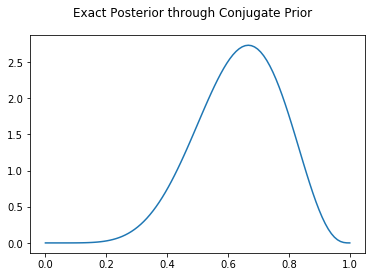

In [5]:
x = np.linspace(0,1,100)
posterior_conjugate = stats.beta.pdf(x, a=_alpha, b=_beta)

fig, ax = plt.subplots()
plt.plot(x,posterior_conjugate)
fig.suptitle("Exact Posterior through Conjugate Prior")

In [6]:
posterior_conjugate[20] / posterior_conjugate[70]

0.010997121265937769

In [7]:
np.log(posterior_conjugate[20]) - np.log(posterior_conjugate[70])

-4.510121743530564

### Pros
* Posterior distribution is exact. It is *not* an estimation
* Most computationally efficient

### Cons
* Requires advanced math to create analytical solution
* Only simple problems have been solved (https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions)

## Grid Search
Steps
1. Generate a grid of points
2. Calculate likelihood for each point
3. For each beta take another grid of points to get probability
4. Calculate likelihood and posterior

In [8]:
possible_probabilities = np.linspace(0,1,100)
prior = np.repeat(5,100)
likelihood = stats.binom.pmf(water_observations, total_observations, possible_probabilities)

posterior_unstandardized = likelihood * prior
posterior_grid_search = posterior_unstandardized / sum(posterior_unstandardized)

Text(0.5, 0.98, 'Posterior through Grid Approximation')

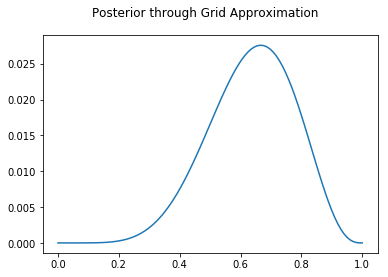

In [9]:
fig, ax = plt.subplots()
plt.plot(possible_probabilities, posterior_grid_search)
fig.suptitle("Posterior through Grid Approximation")

In [10]:
posterior_grid_search[20] / posterior_grid_search[70]

0.010997121265937769

In [11]:
np.log(posterior_grid_search[20]) - np.log(posterior_grid_search[70])

-4.510121743530563

### Pros
* Conceptually simple
* Can theoretically be used to solve any problems

### Cons
* Combinatorics will mean that solution scales very poorly. Sun will explode before some models complete

## Quadratic (Laplace) Approximation
http://www.sumsar.net/blog/2013/11/easy-laplace-approximation/  
https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_02.ipynb

In [12]:
with pm.Model() as normal_aproximation:
    p = pm.Uniform('p', 0, 1)
    w = pm.Binomial('w', n=total_observations, p=p, observed=water_observations)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

/home/canyon/miniconda3/envs/arviz/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.8075, ||grad|| = 1.5: 100%|██████████| 7/7 [00:00<00:00, 2285.55it/s]


(array(0.66666667), array([0.15713484]))

Text(0.5, 0.98, 'Posterior Approximation through Quadratic Approximation')

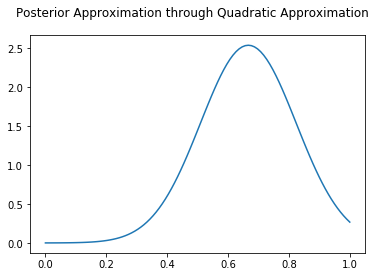

In [13]:
possible_probabilities = np.linspace(0,1,100)
posterior_laplace = stats.norm.pdf(possible_probabilities, mean_q['p'], std_q)
fig, ax = plt.subplots()
plt.plot(possible_probabilities, posterior_laplace)
fig.suptitle("Posterior Approximation through Quadratic Approximation")

In [16]:
posterior_laplace[20] / posterior_laplace[70]

0.013051620301393287

### Pros
* Fast

### Cons
* Normal distributions can't approximate everything

## Markov Chain Monte Carlo

### "Hand built" Metroplis Hastings
https://twiecki.io/blog/2015/11/10/mcmc-sampling/  
http://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/

In [17]:
samples = 5000
proposal_width = .1
p_accept = .5

# Assume Normal Prior for this example
p_water_current = .5
p_water_prior_normal_mu = .5
p_water_prior_normal_sd = 1

mh_posterior = []
for i in range(samples):
    # Proposal Normal distribution
    p_water_proposal = stats.norm(p_water_current, proposal_width).rvs()
    
    # Calculate likelihood of each
    likelihood_current = stats.binom.pmf(water_observations, total_observations, p_water_current)
    likelihood_proposal = stats.binom.pmf(water_observations, total_observations, p_water_proposal)

    # Convert likelihoods that evaluate to nans to zero
    likelihood_current = np.nan_to_num(likelihood_current)
    likelihood_proposal = np.nan_to_num(likelihood_proposal)
    
    # Calculate prior value given proposal and current
    prior_current = stats.norm(p_water_prior_normal_mu, p_water_prior_normal_sd).pdf(p_water_current)
    prior_proposal = stats.norm(p_water_prior_normal_mu, p_water_prior_normal_sd).pdf(p_water_proposal)

    # Calculate posterior probability of current and proposals
    p_current = likelihood_current * prior_current
    p_proposal = likelihood_proposal * prior_proposal
    
    p_accept = p_proposal / p_current
    
    if np.random.rand() < p_accept:
        p_water_current = p_water_proposal
    
    assert p_water_current > 0

    mh_posterior.append(p_water_current)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f17b885d828>],
      dtype=object)

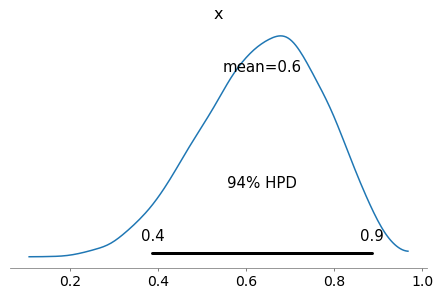

In [18]:
mh_posterior= np.asarray(mh_posterior)
az.plot_posterior(mh_posterior)

In [19]:
np.asarray(mh_posterior)

array([0.5       , 0.60301627, 0.60766987, ..., 0.52253586, 0.52253586,
       0.52676094])

### Estimate local probabilty
Because MCMC provides 

In [20]:
def estimate_prob_ratio_from_samples(mcmc_posterior, prob_1=.2, prob_2=.7, width=.05):
    
    num_samples_1 = np.sum(np.isclose(prob_1, mcmc_posterior, rtol=0, atol=width))
    num_samples_2 = np.sum(np.isclose(prob_2, mcmc_posterior, rtol=0, atol=width))
    return num_samples_1/num_samples_2
    
estimate_prob_ratio_from_samples(mh_posterior)

0.009945079412201277

## PyMC3 MCMC Hamilton Monte Carlo (Specifically Nuts)
PyMC3 makes things so easy

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 7128.43draws/s]
/home/canyon/repos/arviz/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f17b1893588>],
      dtype=object)

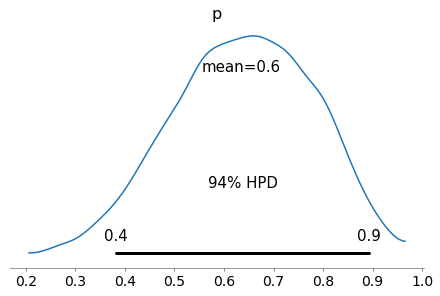

In [36]:
with pm.Model() as mcmc_nuts:
    p_water = pm.Uniform("p", 0 ,1)
    w = pm.Binomial("w", p=p_water, n=total_observations, observed=water_observations)
    trace = pm.sample()
    
az.plot_posterior(trace)

## Stan MCMC Hamilton Monte Carlo

## PyMC3 ADVI